CNN (VGG16) + SVM (NO PCA) + Hyperparameter Tuning - Tea Leaf Disease Detection
Found 2000 images belonging to 5 classes.
Found 298 images belonging to 5 classes.
Found 597 images belonging to 5 classes.
Detected classes: {'1. Tea algal leaf spot': 0, '2. Brown Blight': 1, '4. Helopeltis': 2, '5. Red spider': 3, '7. Healthy leaf': 4}

Extracting CNN features using VGG16 (ImageNet weights)...


C:\Users\Sagala Rasanjana\Desktop\IT24100705_Models\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


125/125 ━━━━━━━━━━━━━━━━━━━━ 76s 605ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 631ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 23s 616ms/step

Feature shapes:
Train: (2000, 512)
Val:   (298, 512)
Test:  (597, 512)

STEP 3: HYPERPARAMETER TUNING USING RANDOMIZED SEARCH 
Fitting 5 folds for each of 25 candidates, totalling 125 fits

Tuning time: 0.33 minutes

Best parameters found:
{'svm__C': np.float64(47.6591180868084), 'svm__class_weight': None, 'svm__gamma': 0.001, 'svm__kernel': 'rbf'}
Best CV F1 (weighted): 0.769143650482555

STEP 4: TEST SET EVALUATION 
Accuracy : 0.7420
Precision: 0.7460
Recall   : 0.7420
F1-score : 0.7433

Classification Report:
                        precision    recall  f1-score   support

1. Tea algal leaf spot       0.49      0.53      0.51        83
       2. Brown Blight       0.61      0.64      0.63       101
         4. Helopeltis       0.88      0.81      0.84       122
         5. Red spider       0.72      0.66      0.69       103
       7. Healthy leaf       0.8

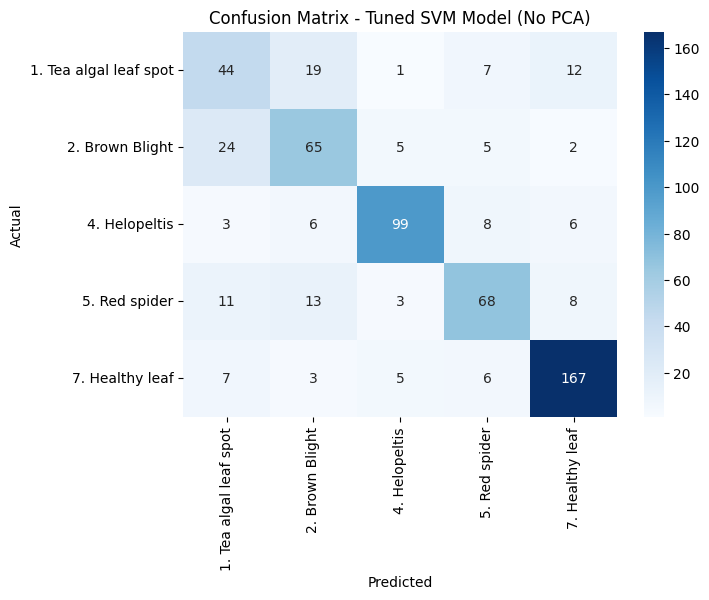


STEP 5: MODEL VARIATION COMPARISON 

Training SVM Linear ...

Training SVM RBF ...

Model Comparison Summary:


,Model,Accuracy,Precision,Recall,F1-score
0,SVM Linear,0.678392,0.697878,0.678392,0.686507
1,SVM RBF,0.720268,0.732802,0.720268,0.725252


✓ Results saved to 'svm_model_comparison_no_pca.csv'
✓ Final model and class mapping saved successfully.

 CNN (VGG16) + SVM PIPELINE COMPLETE 


In [8]:
# ======================================================================
# CNN (VGG16) + SVM + Hyperparameter Tuning - Tea Leaf Disease Detection (RandomizedSearchCV )
# ======================================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib

# Deep Learning
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, precision_score, recall_score, f1_score
)
from scipy.stats import loguniform

# Reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("="*80)
print("CNN (VGG16) + SVM (NO PCA) + Hyperparameter Tuning - Tea Leaf Disease Detection")
print("="*80)

# ======================================================================
# STEP 1: LOAD DATASET
# ======================================================================

base_dir = "Final_Preprocessed_Dataset"

train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 16

datagen = ImageDataGenerator(rescale=1./255)

train_data = datagen.flow_from_directory(train_dir, target_size=(IMG_HEIGHT, IMG_WIDTH),
                                         batch_size=BATCH_SIZE, class_mode='sparse', shuffle=False)
val_data = datagen.flow_from_directory(val_dir, target_size=(IMG_HEIGHT, IMG_WIDTH),
                                       batch_size=BATCH_SIZE, class_mode='sparse', shuffle=False)
test_data = datagen.flow_from_directory(test_dir, target_size=(IMG_HEIGHT, IMG_WIDTH),
                                        batch_size=BATCH_SIZE, class_mode='sparse', shuffle=False)

class_indices = train_data.class_indices
print("Detected classes:", class_indices)

# ======================================================================
# STEP 2: FEATURE EXTRACTION (TensorFlow VGG16)
# ======================================================================

print("\nExtracting CNN features using VGG16 (ImageNet weights)...")

vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
vgg_base.trainable = False

gap = GlobalAveragePooling2D()(vgg_base.output)
feature_model = Model(inputs=vgg_base.input, outputs=gap)

train_features = feature_model.predict(train_data, verbose=1)
val_features = feature_model.predict(val_data, verbose=1)
test_features = feature_model.predict(test_data, verbose=1)

train_labels = train_data.classes
val_labels = val_data.classes
test_labels = test_data.classes

print("\nFeature shapes:")
print("Train:", train_features.shape)
print("Val:  ", val_features.shape)
print("Test: ", test_features.shape)

# ======================================================================
# STEP 3: SVM HYPERPARAMETER TUNING (RandomizedSearchCV) - NO PCA
# ======================================================================

print("\n" + "="*80)
print("STEP 3: HYPERPARAMETER TUNING USING RANDOMIZED SEARCH ")
print("="*80)

X = np.vstack([train_features, val_features])
y = np.concatenate([train_labels, val_labels])

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC())
])

param_distributions = {
    'svm__kernel': ['linear', 'rbf'],
    'svm__C': loguniform(1e-3, 1e3),
    'svm__gamma': ['scale', 'auto', 1e-3, 1e-4],
    'svm__class_weight': [None, 'balanced']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rs = RandomizedSearchCV(pipe, param_distributions=param_distributions,
                        n_iter=25, scoring='f1_weighted', cv=cv, n_jobs=-1,
                        verbose=2, random_state=42)

start = time.time()
rs.fit(X, y)
print("\nTuning time: %.2f minutes" % ((time.time()-start)/60))

print("\nBest parameters found:")
print(rs.best_params_)
print("Best CV F1 (weighted):", rs.best_score_)

best_model = rs.best_estimator_
joblib.dump(best_model, "best_svm_tuned_model_no_pca.joblib")

# ======================================================================
# STEP 4: EVALUATION ON TEST SET
# ======================================================================

print("\n" + "="*80)
print("STEP 4: TEST SET EVALUATION ")
print("="*80)

X_test_scaled = best_model.named_steps['scaler'].transform(test_features)
y_pred = best_model.named_steps['svm'].predict(X_test_scaled)

acc = accuracy_score(test_labels, y_pred)
prec = precision_score(test_labels, y_pred, average='weighted', zero_division=0)
rec = recall_score(test_labels, y_pred, average='weighted', zero_division=0)
f1 = f1_score(test_labels, y_pred, average='weighted', zero_division=0)

print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")

print("\nClassification Report:")
print(classification_report(test_labels, y_pred, target_names=list(class_indices.keys())))

plt.figure(figsize=(7,5))
cm = confusion_matrix(test_labels, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_indices.keys(), yticklabels=class_indices.keys())
plt.title("Confusion Matrix - Tuned SVM Model (No PCA)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ======================================================================
# STEP 5: MODEL COMPARISON TABLE (Only kernel variations)
# ======================================================================

print("\n" + "="*80)
print("STEP 5: MODEL VARIATION COMPARISON ")
print("="*80)

models = [
    {'name': 'SVM Linear', 'kernel': 'linear'},
    {'name': 'SVM RBF', 'kernel': 'rbf'}
]

results = []
for m in models:
    print(f"\nTraining {m['name']} ...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(train_features)
    X_val_scaled = scaler.transform(val_features)
    X_test_scaled = scaler.transform(test_features)

    svm = SVC(kernel=m['kernel'], C=rs.best_params_['svm__C'],
              gamma='scale', class_weight='balanced')
    svm.fit(X_train_scaled, train_labels)
    y_pred = svm.predict(X_test_scaled)

    acc = accuracy_score(test_labels, y_pred)
    prec = precision_score(test_labels, y_pred, average='weighted', zero_division=0)
    rec = recall_score(test_labels, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(test_labels, y_pred, average='weighted', zero_division=0)

    results.append({'Model': m['name'], 'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1-score': f1})

df_results = pd.DataFrame(results)
print("\nModel Comparison Summary:")
display(df_results)
df_results.to_csv("svm_model_comparison_no_pca.csv", index=False)
print("✓ Results saved to 'svm_model_comparison_no_pca.csv'")

# ======================================================================
# STEP 6: SAVE FINAL MODEL
# ======================================================================

joblib.dump(best_model, "final_svm_cnn_model_no_pca.joblib")
joblib.dump(class_indices, "class_indices.joblib")
print("✓ Final model and class mapping saved successfully.")

print("\n" + "="*80)
print(" CNN (VGG16) + SVM PIPELINE COMPLETE ")
print("="*80)


CNN (VGG16) + SVM (NO PCA) + MANUAL PARAMETER TUNING - Tea Leaf Disease Detection
Found 2000 images belonging to 5 classes.
Found 298 images belonging to 5 classes.
Found 597 images belonging to 5 classes.
Detected classes: {'1. Tea algal leaf spot': 0, '2. Brown Blight': 1, '4. Helopeltis': 2, '5. Red spider': 3, '7. Healthy leaf': 4}

Extracting CNN features using VGG16 (ImageNet weights)...


C:\Users\Sagala Rasanjana\Desktop\IT24100705_Models\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


125/125 ━━━━━━━━━━━━━━━━━━━━ 85s 679ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step

Feature shapes:
Train: (2000, 512)
Val:   (298, 512)
Test:  (597, 512)

STEP 3: MANUAL PARAMETER TUNING

Training SVM with parameters: {'kernel': 'linear', 'C': 1}
→ Accuracy: 0.6409, Precision: 0.6541, Recall: 0.6409, F1: 0.6433

Training SVM with parameters: {'kernel': 'linear', 'C': 10}
→ Accuracy: 0.6409, Precision: 0.6541, Recall: 0.6409, F1: 0.6433

Training SVM with parameters: {'kernel': 'rbf', 'C': 1, 'gamma': 'scale'}
→ Accuracy: 0.6644, Precision: 0.6668, Recall: 0.6644, F1: 0.6653

Training SVM with parameters: {'kernel': 'rbf', 'C': 10, 'gamma': 0.001}
→ Accuracy: 0.6678, Precision: 0.6781, Recall: 0.6678, F1: 0.6708

Training SVM with parameters: {'kernel': 'rbf', 'C': 100, 'gamma': 0.0001}
→ Accuracy: 0.6577, Precision: 0.6673, Recall: 0.6577, F1: 0.6609

Tuning time: 0.03 minutes

Manual Tuning Results Summary:


,Params,Accuracy,Precision,Recall,F1
0,"{'kernel': 'linear', 'C': 1}",0.640940,0.654063,0.640940,0.643308
1,"{'kernel': 'linear', 'C': 10}",0.640940,0.654063,0.640940,0.643308
2,"{'kernel': 'rbf', 'C': 1, 'gamma': 'scale'}",0.664430,0.666792,0.664430,0.665275
3,"{'kernel': 'rbf', 'C': 10, 'gamma': 0.001}",0.667785,0.678061,0.667785,0.670846
4,"{'kernel': 'rbf', 'C': 100, 'gamma': 0.0001}",0.657718,0.667270,0.657718,0.660857



Best Parameters Found Manually: {'kernel': 'rbf', 'C': 10, 'gamma': 0.001}
✓ Best manual SVM model saved to 'best_svm_manual_tuned_model.joblib'

STEP 4: TEST SET EVALUATION (Manual Tuning)
Accuracy : 0.7219
Precision: 0.7313
Recall   : 0.7219
F1-score : 0.7258

Classification Report:
                        precision    recall  f1-score   support

1. Tea algal leaf spot       0.44      0.49      0.47        83
       2. Brown Blight       0.55      0.58      0.57       101
         4. Helopeltis       0.89      0.80      0.84       122
         5. Red spider       0.69      0.66      0.68       103
       7. Healthy leaf       0.87      0.88      0.88       188

              accuracy                           0.72       597
             macro avg       0.69      0.68      0.69       597
          weighted avg       0.73      0.72      0.73       597



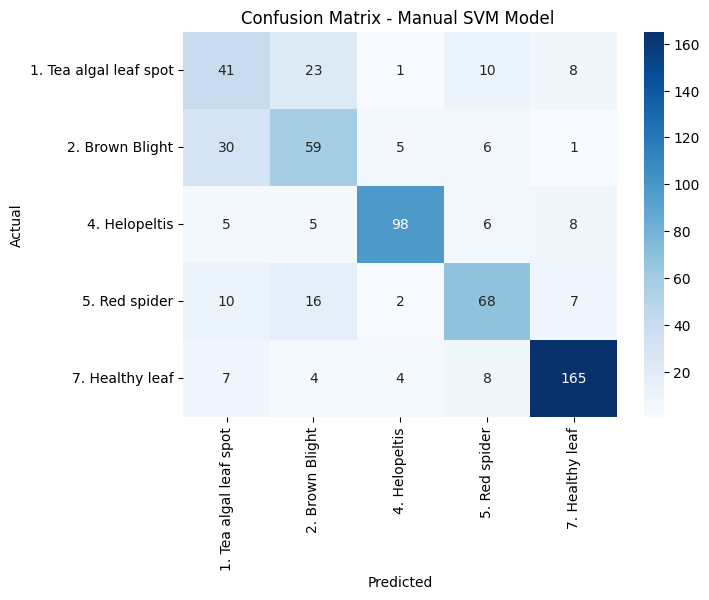


STEP 5: MODEL VARIATION COMPARISON

Training SVM Linear (C=1) ...

Training SVM Linear (C=10) ...

Training SVM RBF (C=10, gamma=0.001) ...

Training SVM RBF (C=100, gamma=0.0001) ...

Model Comparison Summary:


,Model,Accuracy,Precision,Recall,F1-score
0,SVM Linear (C=1),0.678392,0.697878,0.678392,0.686507
1,SVM Linear (C=10),0.678392,0.697878,0.678392,0.686507
2,"SVM RBF (C=10, gamma=0.001)",0.721943,0.731273,0.721943,0.725781
3,"SVM RBF (C=100, gamma=0.0001)",0.720268,0.731775,0.720268,0.725079


✓ Comparison results saved to 'svm_manual_model_comparison.csv'
✓ Final model and class mapping saved successfully.

 CNN (VGG16) + SVM PIPELINE COMPLETE (MANUAL TUNING)


In [10]:
# ======================================================================
# CNN (VGG16) + SVM + Manual Parameter Tuning - Tea Leaf Disease Detection
# ======================================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib

# Deep Learning
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, precision_score, recall_score, f1_score
)

# Reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("="*80)
print("CNN (VGG16) + SVM (NO PCA) + MANUAL PARAMETER TUNING - Tea Leaf Disease Detection")
print("="*80)

# ======================================================================
# STEP 1: LOAD DATASET
# ======================================================================

base_dir = "Final_Preprocessed_Dataset"

train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 16

datagen = ImageDataGenerator(rescale=1./255)

train_data = datagen.flow_from_directory(train_dir, target_size=(IMG_HEIGHT, IMG_WIDTH),
                                         batch_size=BATCH_SIZE, class_mode='sparse', shuffle=False)
val_data = datagen.flow_from_directory(val_dir, target_size=(IMG_HEIGHT, IMG_WIDTH),
                                       batch_size=BATCH_SIZE, class_mode='sparse', shuffle=False)
test_data = datagen.flow_from_directory(test_dir, target_size=(IMG_HEIGHT, IMG_WIDTH),
                                        batch_size=BATCH_SIZE, class_mode='sparse', shuffle=False)

class_indices = train_data.class_indices
print("Detected classes:", class_indices)

# ======================================================================
# STEP 2: FEATURE EXTRACTION (TensorFlow VGG16)
# ======================================================================

print("\nExtracting CNN features using VGG16 (ImageNet weights)...")

vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
vgg_base.trainable = False

gap = GlobalAveragePooling2D()(vgg_base.output)
feature_model = Model(inputs=vgg_base.input, outputs=gap)

train_features = feature_model.predict(train_data, verbose=1)
val_features = feature_model.predict(val_data, verbose=1)
test_features = feature_model.predict(test_data, verbose=1)

train_labels = train_data.classes
val_labels = val_data.classes
test_labels = test_data.classes

print("\nFeature shapes:")
print("Train:", train_features.shape)
print("Val:  ", val_features.shape)
print("Test: ", test_features.shape)

# ======================================================================
# STEP 3: MANUAL PARAMETER TUNING (NO PCA)
# ======================================================================

print("\n" + "="*80)
print("STEP 3: MANUAL PARAMETER TUNING")
print("="*80)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_features)
X_val_scaled = scaler.transform(val_features)

# List of parameters to test manually
params_to_try = [
    {'kernel': 'linear', 'C': 1},
    {'kernel': 'linear', 'C': 10},
    {'kernel': 'rbf', 'C': 1, 'gamma': 'scale'},
    {'kernel': 'rbf', 'C': 10, 'gamma': 0.001},
    {'kernel': 'rbf', 'C': 100, 'gamma': 0.0001},
]

results = []
start = time.time()

for p in params_to_try:
    print(f"\nTraining SVM with parameters: {p}")
    svm = SVC(**p, class_weight='balanced', random_state=42)
    svm.fit(X_train_scaled, train_labels)
    y_pred_val = svm.predict(X_val_scaled)

    acc = accuracy_score(val_labels, y_pred_val)
    prec = precision_score(val_labels, y_pred_val, average='weighted', zero_division=0)
    rec = recall_score(val_labels, y_pred_val, average='weighted', zero_division=0)
    f1 = f1_score(val_labels, y_pred_val, average='weighted', zero_division=0)

    print(f"→ Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")
    results.append({'Params': str(p), 'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1': f1})

end = time.time()
print("\nTuning time: %.2f minutes" % ((end - start) / 60))

df_results = pd.DataFrame(results)
print("\nManual Tuning Results Summary:")
display(df_results)

best_idx = df_results['F1'].idxmax()
best_params = params_to_try[best_idx]
print("\nBest Parameters Found Manually:", best_params)

# Train the best model using best manual parameters
best_model = SVC(**best_params, class_weight='balanced', random_state=42)
best_model.fit(X_train_scaled, train_labels)
joblib.dump(best_model, "best_svm_manual_tuned_model.joblib")
print("✓ Best manual SVM model saved to 'best_svm_manual_tuned_model.joblib'")

# ======================================================================
# STEP 4: EVALUATION ON TEST SET
# ======================================================================

print("\n" + "="*80)
print("STEP 4: TEST SET EVALUATION (Manual Tuning)")
print("="*80)

X_test_scaled = scaler.transform(test_features)
y_pred = best_model.predict(X_test_scaled)

acc = accuracy_score(test_labels, y_pred)
prec = precision_score(test_labels, y_pred, average='weighted', zero_division=0)
rec = recall_score(test_labels, y_pred, average='weighted', zero_division=0)
f1 = f1_score(test_labels, y_pred, average='weighted', zero_division=0)

print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")

print("\nClassification Report:")
print(classification_report(test_labels, y_pred, target_names=list(class_indices.keys())))

plt.figure(figsize=(7,5))
cm = confusion_matrix(test_labels, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_indices.keys(), yticklabels=class_indices.keys())
plt.title("Confusion Matrix - Manual SVM Model ")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ======================================================================
# STEP 5: MODEL VARIATION COMPARISON (Only kernels)
# ======================================================================

print("\n" + "="*80)
print("STEP 5: MODEL VARIATION COMPARISON")
print("="*80)

models = [
    {'name': 'SVM Linear (C=1)', 'kernel': 'linear', 'C': 1},
    {'name': 'SVM Linear (C=10)', 'kernel': 'linear', 'C': 10},
    {'name': 'SVM RBF (C=10, gamma=0.001)', 'kernel': 'rbf', 'C': 10, 'gamma': 0.001},
    {'name': 'SVM RBF (C=100, gamma=0.0001)', 'kernel': 'rbf', 'C': 100, 'gamma': 0.0001},
]

comparison_results = []

for m in models:
    print(f"\nTraining {m['name']} ...")
    svm = SVC(kernel=m['kernel'], C=m['C'], gamma=m.get('gamma', 'scale'),
              class_weight='balanced', random_state=42)
    svm.fit(X_train_scaled, train_labels)
    y_pred = svm.predict(X_test_scaled)

    acc = accuracy_score(test_labels, y_pred)
    prec = precision_score(test_labels, y_pred, average='weighted', zero_division=0)
    rec = recall_score(test_labels, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(test_labels, y_pred, average='weighted', zero_division=0)

    comparison_results.append({'Model': m['name'], 'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1-score': f1})

df_comp = pd.DataFrame(comparison_results)
print("\nModel Comparison Summary:")
display(df_comp)
df_comp.to_csv("svm_manual_model_comparison.csv", index=False)
print("✓ Comparison results saved to 'svm_manual_model_comparison.csv'")

# ======================================================================
# STEP 6: SAVE FINAL MODEL
# ======================================================================

joblib.dump(best_model, "final_svm_cnn_manual_model.joblib")
joblib.dump(class_indices, "class_indices.joblib")
print("✓ Final model and class mapping saved successfully.")

print("\n" + "="*80)
print(" CNN (VGG16) + SVM PIPELINE COMPLETE (MANUAL TUNING)")
print("="*80)
